In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import re # Regex
import string # String manipulation
import spacy # NLP tooling
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf # Deep learning
import matplotlib.pyplot as plt # Visualization
from sklearn.model_selection import train_test_split # Split train and validation set
from sklearn.preprocessing import LabelEncoder # Encode label into numerical format

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ag-news-classification-dataset/train.csv
/kaggle/input/ag-news-classification-dataset/test.csv


In [ ]:
nlp = spacy.load('en_core_web_sm', parser=False, entity=False)  
df_train = pd.read_csv('../input/ag-news-classification-dataset/train.csv')
df_test = pd.read_csv('../input/ag-news-classification-dataset/test.csv')
df_train

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."
...,...,...,...
119995,1,Pakistan's Musharraf Says Won't Quit as Army C...,KARACHI (Reuters) - Pakistani President Perve...
119996,2,Renteria signing a top-shelf deal,Red Sox general manager Theo Epstein acknowled...
119997,2,Saban not going to Dolphins yet,The Miami Dolphins will put their courtship of...
119998,2,Today's NFL games,PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: ...


In [ ]:
def clean_text(text):
    regex_html = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    remove_digits = str.maketrans('', '', string.digits + string.punctuation)
    text = re.sub(regex_html, '', text)
    text = text.translate(remove_digits)
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", text).split()).lower()

df_train['text'] = (df_train.Title + " " + df_train.Description).apply(clean_text)
#\.apply(nlp).apply(lambda x: " ".join(token.lemma_ for token in x if not token.is_stop).lower())
df_test['text'] = (df_test.Title + " " + df_test.Description).apply(clean_text)
#\.apply(nlp).apply(lambda x: " ".join(token.lemma_ for token in x if not token.is_stop).lower())

In [ ]:
le = LabelEncoder().fit(df_train['Class Index'])
df_train['label'] = le.transform(df_train['Class Index'])
df_test['label'] = le.transform(df_test['Class Index'])
train, val = train_test_split(df_train, test_size=0.2, random_state=42, stratify=df_train.label)

In [ ]:
df_train[['text', 'label']]

,text,label
0,wall st bears claw back into the black reuters...,2
1,carlyle looks toward commercial aerospace reut...,2
2,oil and economy cloud stocks outlook reuters r...,2
3,iraq halts oil exports from main southern pipe...,2
4,oil prices soar to alltime record posing new m...,2
...,...,...
119995,pakistans musharraf says wont quit as army chi...,0
119996,renteria signing a topshelf deal red sox gener...,1
119997,saban not going to dolphins yet the miami dolp...,1
119998,todays nfl games pittsburgh at ny giants time ...,1


In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=8192, oov_token='-')
tokenizer.fit_on_texts(train.text)

x_train = tf.keras.preprocessing.sequence.pad_sequences(
    tokenizer.texts_to_sequences(train.text), 
    maxlen=128, 
    padding='post', 
    truncating='post'
)
x_val = tf.keras.preprocessing.sequence.pad_sequences(
    tokenizer.texts_to_sequences(val.text), 
    maxlen=128, 
    padding='post', 
    truncating='post'
)
x_test = tf.keras.preprocessing.sequence.pad_sequences(
    tokenizer.texts_to_sequences(df_test.text), 
    maxlen=128, 
    padding='post', 
    truncating='post'
)

y_train = train.label
y_val = val.label
y_test = df_test.label

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Input((64,)),
    tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index), output_dim=64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(set(df_train.label)), activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 64, 64)            5251840   
_________________________________________________________________
bidirectional (Bidirectional (None, 64, 256)           197632    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1028      
Total params: 5,516,292
Trainable params: 5,516,292
Non-trainable params: 0
______________________________________________

In [ ]:
history = model.fit(
    x_train, 
    y_train, 
    epochs=50, 
    validation_data=(x_val, y_val),
    batch_size=32,
    callbacks=[tf.keras.callbacks.EarlyStopping(
        patience=5, 
        restore_best_weights=True,
    ), tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        patience=2
    )]
)

Epoch 1/50
3000/3000 [==============================] - 181s 59ms/step - loss: 0.5285 - accuracy: 0.7888 - val_loss: 0.2549 - val_accuracy: 0.9129
Epoch 2/50
3000/3000 [==============================] - 174s 58ms/step - loss: 0.2231 - accuracy: 0.9255 - val_loss: 0.2409 - val_accuracy: 0.9160
Epoch 3/50
3000/3000 [==============================] - 178s 59ms/step - loss: 0.1829 - accuracy: 0.9364 - val_loss: 0.2492 - val_accuracy: 0.9168
Epoch 4/50
3000/3000 [==============================] - 177s 59ms/step - loss: 0.1451 - accuracy: 0.9474 - val_loss: 0.2815 - val_accuracy: 0.9143
Epoch 5/50
3000/3000 [==============================] - 177s 59ms/step - loss: 0.0963 - accuracy: 0.9653 - val_loss: 0.3149 - val_accuracy: 0.9146
Epoch 6/50
3000/3000 [==============================] - 178s 59ms/step - loss: 0.0801 - accuracy: 0.9708 - val_loss: 0.3496 - val_accuracy: 0.9134
Epoch 7/50
3000/3000 [==============================] - 176s 59ms/step - loss: 0.0638 - accuracy: 0.9763 - val_loss: 0

In [ ]:
eval_result = model.evaluate(x_test, y_test)

238/238 [==============================] - 2s 7ms/step - loss: 0.2520 - accuracy: 0.9157


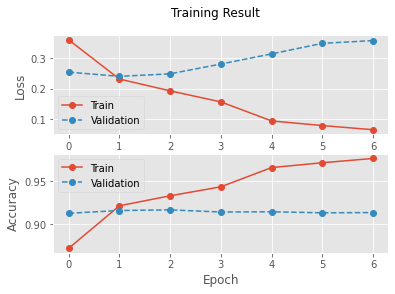

In [ ]:
plt.style.use('ggplot')
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
fig.suptitle('Training Result')
ax1.plot(history.history['loss'], 'o-', label='Train')
ax1.plot(history.history['val_loss'], 'o--', label='Validation')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(history.history['accuracy'], 'o-', label='Train')
ax2.plot(history.history['val_accuracy'], 'o--', label='Validation')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()